In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io as io
import scipy
import sys
sys.path.insert(0, '../../')
from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

In [2]:
seed = 11
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

In [3]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,1], [0,30], 50, 128)
res_test, _, _, _, _ = get_data([0,1], [0,30], 50, 128)
num_step=3
step=1e-1
res = make_time_sequence(res, num_step=num_step, step=step)
b_left = make_time_sequence(b_left, num_step=num_step, step=step)
b_right = make_time_sequence(b_right, num_step=num_step, step=step)
b_upper = make_time_sequence(b_upper, num_step=num_step, step=step)
b_lower = make_time_sequence(b_lower, num_step=num_step, step=step)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [4]:
model = PINNsformer(d_out=2, d_hidden=512, d_model=32, N=1, heads=1).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

C:\Windows\Temp\ipykernel_90288\4265907048.py:26: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


In [5]:
def model_SIR(x, t):
    SIR = model(x, t)
    S = SIR[:,:, 0]
    I = SIR[:,:, 1]
    S = S.unsqueeze(-1)
    I = I.unsqueeze(-1)
    return S, I

In [6]:
loss_track = []

for i in tqdm(range(20)):
    def closure():
        pred_res, pred_rei = model_SIR(x_res, t_res)
        preds_left, predi_left = model_SIR(x_left, t_left)
        preds_right, predi_right = model_SIR(x_right, t_right)
        preds_upper, predi_upper = model_SIR(x_upper, t_upper)
        preds_lower, predi_lower = model_SIR(x_lower, t_lower)

        S_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        S_xx = torch.autograd.grad(S_x, x_res, grad_outputs=torch.ones_like(S_x), create_graph=True)[0]
        S_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        I_x = torch.autograd.grad(pred_rei, x_res, grad_outputs=torch.ones_like(pred_rei), retain_graph=True, create_graph=True)[0]
        I_xx = torch.autograd.grad(I_x, x_res, grad_outputs=torch.ones_like(I_x), create_graph=True)[0]
        I_t = torch.autograd.grad(pred_rei, t_res, grad_outputs=torch.ones_like(pred_rei), retain_graph=True, create_graph=True)[0]

        def bc_loss_upper(x, t):
            pred_res, pred_rei = model_SIR(x, t)
            S_x = torch.autograd.grad(pred_res, x, grad_outputs=torch.ones_like(pred_res), create_graph=True)[0]
            I_x = torch.autograd.grad(pred_rei, x, grad_outputs=torch.ones_like(pred_rei), create_graph=True)[0]
            return S_x, I_x

        def bc_loss_lower(x, t):
            pred_res, pred_rei = model_SIR(x, t)
            S_x = torch.autograd.grad(pred_res, x, grad_outputs=torch.ones_like(pred_res), create_graph=True)[0]
            I_x = torch.autograd.grad(pred_rei, x, grad_outputs=torch.ones_like(pred_rei), create_graph=True)[0]
            return S_x, I_x

        pde1 = S_t - 0.001 * S_xx + 0.5 * pred_res * pred_rei - 0.1 + 0.1 * pred_res
        pde2 = I_t - 0.001 * I_xx - 0.5 * pred_res * pred_rei + 0.5 * pred_rei + 0.1 * pred_rei

        loss_res = torch.mean(pde1 ** 2) + torch.mean(pde2 ** 2)

        loss_bcs_1, loss_bci_1 = bc_loss_upper(x_upper, t_upper)
        loss_bcs_2, loss_bci_2 = bc_loss_lower(x_lower, t_lower)
        loss_bcs_1 = torch.mean(loss_bcs_1[:,0] ** 2)
        loss_bci_1 = torch.mean(loss_bci_1[:,0] ** 2)
        loss_bcs_2 = torch.mean(loss_bcs_2[:,0] ** 2)
        loss_bci_2 = torch.mean(loss_bci_2[:,0] ** 2)
        loss_bc = loss_bcs_1 + loss_bci_1 + loss_bcs_2 + loss_bci_2

        # loss_ic = torch.mean((preds_left[:,0]-S_Exact[:,0]) ** 2) + torch.mean((predi_left[:,0]-I_Exact[:,0]) ** 2)
        x_coord = x_left[:, 0]  # 获取 x 坐标值
        
        # 创建分段条件掩码
        mask_less = x_coord < 0.5          # 左半区条件 (0 ≤ x < 0.5)
        mask_ge = x_coord >= 0.5           # 右半区条件 (0.5 ≤ x ≤ 1)
        
        # 计算理论值 (注意用 torch.where 保持张量设备一致)
        true_ics = torch.where(
            mask_less,
            1.1 * x_coord,                # 左半区：1.1x
            1.1 * (1 - x_coord)           # 右半区：1.1(1-x)
        )

        true_ici = torch.where(
            mask_less,
            0.5 * x_coord,                # 左半区：1.1x
            0.5 * (1 - x_coord)           # 右半区：1.1(1-x)
        )
        
        # 计算初始条件损失
        loss_ic1 = torch.mean((preds_left[:, 0] - true_ics) ** 2)
        loss_ic2 = torch.mean((predi_left[:, 0] - true_ici) ** 2)
        loss_ic = loss_ic1 + loss_ic2
        
        # loss_ic = torch.mean((preds_left[:, 0]-S_Exact[0, :]) ** 2) + torch.mean((predi_left[:, 0]-I_Exact[0, :]) ** 2)

        current_losses = [loss_res.item(), loss_bc.item(), loss_ic.item()]
        loss_track.append(current_losses)

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        
        # Print losses for this iteration
        print(f'Iteration {i+1}: Total Loss: {sum(current_losses):.4f}, Loss Res: {current_losses[0]:.4f}, Loss_BC: {current_losses[1]:.4f}, Loss_IC: {current_losses[2]:.4f}')
        
        return loss

    optim.step(closure)

# Final output remains the same
print('Final Losses - Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Final Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Iteration 1: Total Loss: 0.8346, Loss Res: 0.1456, Loss_BC: 0.0783, Loss_IC: 0.6107
Iteration 1: Total Loss: 0.7584, Loss Res: 0.1444, Loss_BC: 0.0773, Loss_IC: 0.5367
Iteration 1: Total Loss: 0.3009, Loss Res: 0.1355, Loss_BC: 0.0703, Loss_IC: 0.0951
Iteration 1: Total Loss: 0.2084, Loss Res: 0.1126, Loss_BC: 0.0623, Loss_IC: 0.0335
Iteration 1: Total Loss: 0.1866, Loss Res: 0.0968, Loss_BC: 0.0561, Loss_IC: 0.0337
Iteration 1: Total Loss: 0.1009, Loss Res: 0.0204, Loss_BC: 0.0195, Loss_IC: 0.0610
Iteration 1: Total Loss: 0.0854, Loss Res: 0.0159, Loss_BC: 0.0185, Loss_IC: 0.0510
Iteration 1: Total Loss: 0.0604, Loss Res: 0.0137, Loss_BC: 0.0153, Loss_IC: 0.0313
Iteration 1: Total Loss: 0.0580, Loss Res: 0.0129, Loss_BC: 0.0139, Loss_IC: 0.0312
Iteration 1: Total Loss: 0.0519, Loss Res: 0.0103, Loss_BC: 0.0098, Loss_IC: 0.0317
Iteration 1: Total Loss: 0.0465, Loss Res: 0.0082, Loss_BC: 0.0067, Loss_IC: 0.0315
Iteration 1: Total Loss: 0.0406, Loss Res: 0.0059, Loss_BC: 0.0037, Loss_IC:

  5%|████▏                                                                              | 1/20 [01:04<20:19, 64.18s/it]

Iteration 1: Total Loss: 0.0307, Loss Res: 0.0005, Loss_BC: 0.0012, Loss_IC: 0.0291
Iteration 2: Total Loss: 0.0307, Loss Res: 0.0005, Loss_BC: 0.0012, Loss_IC: 0.0291
Iteration 2: Total Loss: 0.0305, Loss Res: 0.0005, Loss_BC: 0.0011, Loss_IC: 0.0289
Iteration 2: Total Loss: 0.0303, Loss Res: 0.0005, Loss_BC: 0.0011, Loss_IC: 0.0287
Iteration 2: Total Loss: 0.0301, Loss Res: 0.0005, Loss_BC: 0.0011, Loss_IC: 0.0285
Iteration 2: Total Loss: 0.0298, Loss Res: 0.0005, Loss_BC: 0.0012, Loss_IC: 0.0281
Iteration 2: Total Loss: 0.0296, Loss Res: 0.0005, Loss_BC: 0.0012, Loss_IC: 0.0278
Iteration 2: Total Loss: 0.0294, Loss Res: 0.0006, Loss_BC: 0.0013, Loss_IC: 0.0275
Iteration 2: Total Loss: 0.0292, Loss Res: 0.0005, Loss_BC: 0.0014, Loss_IC: 0.0273
Iteration 2: Total Loss: 0.0287, Loss Res: 0.0005, Loss_BC: 0.0016, Loss_IC: 0.0266
Iteration 2: Total Loss: 0.0284, Loss Res: 0.0005, Loss_BC: 0.0019, Loss_IC: 0.0259
Iteration 2: Total Loss: 0.0282, Loss Res: 0.0006, Loss_BC: 0.0021, Loss_IC:

 10%|████████▎                                                                          | 2/20 [02:08<19:19, 64.41s/it]

Iteration 2: Total Loss: 0.0263, Loss Res: 0.0009, Loss_BC: 0.0043, Loss_IC: 0.0211
Iteration 3: Total Loss: 0.0263, Loss Res: 0.0009, Loss_BC: 0.0043, Loss_IC: 0.0211
Iteration 3: Total Loss: 0.0262, Loss Res: 0.0008, Loss_BC: 0.0044, Loss_IC: 0.0209
Iteration 3: Total Loss: 0.0260, Loss Res: 0.0008, Loss_BC: 0.0046, Loss_IC: 0.0206
Iteration 3: Total Loss: 0.0257, Loss Res: 0.0009, Loss_BC: 0.0052, Loss_IC: 0.0196
Iteration 3: Total Loss: 0.0254, Loss Res: 0.0009, Loss_BC: 0.0052, Loss_IC: 0.0193
Iteration 3: Total Loss: 0.0252, Loss Res: 0.0009, Loss_BC: 0.0056, Loss_IC: 0.0187
Iteration 3: Total Loss: 0.0250, Loss Res: 0.0009, Loss_BC: 0.0055, Loss_IC: 0.0186
Iteration 3: Total Loss: 0.0248, Loss Res: 0.0009, Loss_BC: 0.0056, Loss_IC: 0.0182
Iteration 3: Total Loss: 0.0243, Loss Res: 0.0010, Loss_BC: 0.0057, Loss_IC: 0.0176
Iteration 3: Total Loss: 0.0240, Loss Res: 0.0013, Loss_BC: 0.0062, Loss_IC: 0.0165
Iteration 3: Total Loss: 0.0235, Loss Res: 0.0014, Loss_BC: 0.0061, Loss_IC:

 15%|████████████▍                                                                      | 3/20 [03:16<18:44, 66.14s/it]

Iteration 3: Total Loss: 0.0183, Loss Res: 0.0032, Loss_BC: 0.0060, Loss_IC: 0.0091
Iteration 4: Total Loss: 0.0183, Loss Res: 0.0032, Loss_BC: 0.0060, Loss_IC: 0.0091
Iteration 4: Total Loss: 0.0171, Loss Res: 0.0039, Loss_BC: 0.0064, Loss_IC: 0.0068
Iteration 4: Total Loss: 0.0164, Loss Res: 0.0041, Loss_BC: 0.0066, Loss_IC: 0.0058
Iteration 4: Total Loss: 0.0153, Loss Res: 0.0030, Loss_BC: 0.0055, Loss_IC: 0.0067
Iteration 4: Total Loss: 0.0140, Loss Res: 0.0032, Loss_BC: 0.0050, Loss_IC: 0.0059
Iteration 4: Total Loss: 0.0129, Loss Res: 0.0033, Loss_BC: 0.0050, Loss_IC: 0.0046
Iteration 4: Total Loss: 0.0123, Loss Res: 0.0033, Loss_BC: 0.0041, Loss_IC: 0.0049
Iteration 4: Total Loss: 0.0120, Loss Res: 0.0026, Loss_BC: 0.0039, Loss_IC: 0.0055
Iteration 4: Total Loss: 0.0118, Loss Res: 0.0026, Loss_BC: 0.0030, Loss_IC: 0.0061
Iteration 4: Total Loss: 0.0111, Loss Res: 0.0028, Loss_BC: 0.0036, Loss_IC: 0.0048
Iteration 4: Total Loss: 0.0109, Loss Res: 0.0028, Loss_BC: 0.0035, Loss_IC:

 20%|████████████████▌                                                                  | 4/20 [04:27<18:08, 68.00s/it]

Iteration 4: Total Loss: 0.0062, Loss Res: 0.0028, Loss_BC: 0.0017, Loss_IC: 0.0017
Iteration 5: Total Loss: 0.0062, Loss Res: 0.0028, Loss_BC: 0.0017, Loss_IC: 0.0017
Iteration 5: Total Loss: 0.0058, Loss Res: 0.0028, Loss_BC: 0.0015, Loss_IC: 0.0015
Iteration 5: Total Loss: 0.0055, Loss Res: 0.0028, Loss_BC: 0.0013, Loss_IC: 0.0014
Iteration 5: Total Loss: 0.0053, Loss Res: 0.0027, Loss_BC: 0.0012, Loss_IC: 0.0014
Iteration 5: Total Loss: 0.0051, Loss Res: 0.0025, Loss_BC: 0.0011, Loss_IC: 0.0015
Iteration 5: Total Loss: 0.0049, Loss Res: 0.0025, Loss_BC: 0.0011, Loss_IC: 0.0014
Iteration 5: Total Loss: 0.0046, Loss Res: 0.0022, Loss_BC: 0.0009, Loss_IC: 0.0014
Iteration 5: Total Loss: 0.0044, Loss Res: 0.0022, Loss_BC: 0.0010, Loss_IC: 0.0013
Iteration 5: Total Loss: 0.0043, Loss Res: 0.0021, Loss_BC: 0.0009, Loss_IC: 0.0013
Iteration 5: Total Loss: 0.0041, Loss Res: 0.0021, Loss_BC: 0.0008, Loss_IC: 0.0012
Iteration 5: Total Loss: 0.0039, Loss Res: 0.0020, Loss_BC: 0.0008, Loss_IC:

 25%|████████████████████▊                                                              | 5/20 [05:40<17:25, 69.70s/it]

Iteration 5: Total Loss: 0.0025, Loss Res: 0.0011, Loss_BC: 0.0005, Loss_IC: 0.0008
Iteration 6: Total Loss: 0.0025, Loss Res: 0.0011, Loss_BC: 0.0005, Loss_IC: 0.0008
Iteration 6: Total Loss: 0.0023, Loss Res: 0.0011, Loss_BC: 0.0005, Loss_IC: 0.0008
Iteration 6: Total Loss: 0.0023, Loss Res: 0.0010, Loss_BC: 0.0004, Loss_IC: 0.0008
Iteration 6: Total Loss: 0.0022, Loss Res: 0.0009, Loss_BC: 0.0005, Loss_IC: 0.0008
Iteration 6: Total Loss: 0.0022, Loss Res: 0.0009, Loss_BC: 0.0005, Loss_IC: 0.0007
Iteration 6: Total Loss: 0.0021, Loss Res: 0.0009, Loss_BC: 0.0005, Loss_IC: 0.0008
Iteration 6: Total Loss: 0.0021, Loss Res: 0.0009, Loss_BC: 0.0004, Loss_IC: 0.0008
Iteration 6: Total Loss: 0.0021, Loss Res: 0.0009, Loss_BC: 0.0004, Loss_IC: 0.0007
Iteration 6: Total Loss: 0.0020, Loss Res: 0.0008, Loss_BC: 0.0004, Loss_IC: 0.0007
Iteration 6: Total Loss: 0.0019, Loss Res: 0.0008, Loss_BC: 0.0004, Loss_IC: 0.0007
Iteration 6: Total Loss: 0.0018, Loss Res: 0.0007, Loss_BC: 0.0004, Loss_IC:

 30%|████████████████████████▉                                                          | 6/20 [06:55<16:43, 71.66s/it]

Iteration 6: Total Loss: 0.0014, Loss Res: 0.0005, Loss_BC: 0.0003, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0014, Loss Res: 0.0005, Loss_BC: 0.0003, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0014, Loss Res: 0.0005, Loss_BC: 0.0002, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0013, Loss Res: 0.0005, Loss_BC: 0.0002, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0013, Loss Res: 0.0005, Loss_BC: 0.0002, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0013, Loss Res: 0.0004, Loss_BC: 0.0002, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0012, Loss Res: 0.0004, Loss_BC: 0.0002, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0012, Loss Res: 0.0004, Loss_BC: 0.0002, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0012, Loss Res: 0.0004, Loss_BC: 0.0002, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0012, Loss Res: 0.0004, Loss_BC: 0.0002, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0011, Loss Res: 0.0004, Loss_BC: 0.0002, Loss_IC: 0.0006
Iteration 7: Total Loss: 0.0011, Loss Res: 0.0004, Loss_BC: 0.0002, Loss_IC:

 35%|█████████████████████████████                                                      | 7/20 [08:11<15:45, 72.77s/it]

Iteration 7: Total Loss: 0.0010, Loss Res: 0.0003, Loss_BC: 0.0001, Loss_IC: 0.0006
Iteration 8: Total Loss: 0.0010, Loss Res: 0.0003, Loss_BC: 0.0001, Loss_IC: 0.0006
Iteration 8: Total Loss: 0.0010, Loss Res: 0.0003, Loss_BC: 0.0001, Loss_IC: 0.0006
Iteration 8: Total Loss: 0.0009, Loss Res: 0.0003, Loss_BC: 0.0001, Loss_IC: 0.0006
Iteration 8: Total Loss: 0.0009, Loss Res: 0.0003, Loss_BC: 0.0001, Loss_IC: 0.0006
Iteration 8: Total Loss: 0.0009, Loss Res: 0.0003, Loss_BC: 0.0001, Loss_IC: 0.0006
Iteration 8: Total Loss: 0.0009, Loss Res: 0.0003, Loss_BC: 0.0001, Loss_IC: 0.0006
Iteration 8: Total Loss: 0.0009, Loss Res: 0.0003, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 8: Total Loss: 0.0009, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 8: Total Loss: 0.0009, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 8: Total Loss: 0.0009, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 8: Total Loss: 0.0009, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC:

 40%|█████████████████████████████████▏                                                 | 8/20 [09:26<14:43, 73.61s/it]

Iteration 8: Total Loss: 0.0008, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 9: Total Loss: 0.0008, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 9: Total Loss: 0.0008, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 9: Total Loss: 0.0008, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 9: Total Loss: 0.0008, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 9: Total Loss: 0.0008, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 9: Total Loss: 0.0008, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 9: Total Loss: 0.0008, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 9: Total Loss: 0.0008, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 9: Total Loss: 0.0007, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 9: Total Loss: 0.0007, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC: 0.0005
Iteration 9: Total Loss: 0.0007, Loss Res: 0.0002, Loss_BC: 0.0001, Loss_IC:

 45%|█████████████████████████████████████▎                                             | 9/20 [10:41<13:35, 74.14s/it]

Iteration 9: Total Loss: 0.0007, Loss Res: 0.0002, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 10: Total Loss: 0.0007, Loss Res: 0.0002, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 10: Total Loss: 0.0007, Loss Res: 0.0002, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 10: Total Loss: 0.0007, Loss Res: 0.0002, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 10: Total Loss: 0.0007, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 10: Total Loss: 0.0007, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 10: Total Loss: 0.0007, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 10: Total Loss: 0.0007, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 10: Total Loss: 0.0007, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 10: Total Loss: 0.0007, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 10: Total Loss: 0.0007, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 10: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.000

 50%|█████████████████████████████████████████                                         | 10/20 [11:57<12:26, 74.65s/it]

Iteration 10: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 11: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 11: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 11: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 11: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 11: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 11: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 11: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 11: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 11: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 11: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 11: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.00

 55%|█████████████████████████████████████████████                                     | 11/20 [13:13<11:15, 75.10s/it]

Iteration 11: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 12: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 12: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 12: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 12: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 12: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 12: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 12: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 12: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 12: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 12: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 12: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.00

 60%|█████████████████████████████████████████████████▏                                | 12/20 [14:29<10:01, 75.24s/it]

Iteration 12: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 13: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 13: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 13: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 13: Total Loss: 0.0006, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 13: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 13: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0005
Iteration 13: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 13: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 13: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 13: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 13: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.00

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [15:45<08:47, 75.43s/it]

Iteration 13: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 14: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 14: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 14: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 14: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 14: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 14: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 14: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 14: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 14: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 14: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 14: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.00

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [16:59<07:31, 75.26s/it]

Iteration 14: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 15: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 15: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 15: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 15: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 15: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 15: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 15: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 15: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 15: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 15: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 15: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.00

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [18:13<06:13, 74.64s/it]

Iteration 15: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 16: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 16: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 16: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 16: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 16: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 16: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 16: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 16: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 16: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 16: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 16: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.00

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [19:26<04:56, 74.18s/it]

Iteration 16: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 17: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 17: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 17: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 17: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 17: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 17: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 17: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 17: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 17: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 17: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 17: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.00

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [20:43<03:44, 74.95s/it]

Iteration 17: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 18: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 18: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 18: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 18: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 18: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 18: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 18: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 18: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 18: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 18: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 18: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.00

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [21:56<02:28, 74.41s/it]

Iteration 18: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 19: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 19: Total Loss: 0.0005, Loss Res: 0.0001, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 19: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 19: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 19: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 19: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 19: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 19: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 19: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 19: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 19: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.00

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [23:09<01:14, 74.09s/it]

Iteration 19: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 20: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 20: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 20: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 20: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 20: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 20: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 20: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 20: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 20: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 20: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Iteration 20: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.00

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [24:22<00:00, 73.14s/it]

Iteration 20: Total Loss: 0.0005, Loss Res: 0.0000, Loss_BC: 0.0000, Loss_IC: 0.0004
Final Losses - Loss Res: 0.000043, Loss_BC: 0.000007, Loss_IC: 0.000414
Final Train Loss: 0.000464


In [13]:
data = scipy.io.loadmat('SIR_beta=0.5_alpha=0.5.mat')
S_Exact = torch.tensor((data['u1'])).to(device)  ## 256时间，100空间
I_Exact = torch.tensor((data['u2'])).to(device)
print(S_Exact.shape)

torch.Size([256, 100])


In [14]:
# Visualize PINNsformer
res_test, _, _, _, _ = get_data([0,1], [0,30], 100, 256)

res_test = make_time_sequence(res_test, num_step=3, step=1e-2) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred_s, pred_i = model_SIR(x_test, t_test)
    pred_s = pred_s[:,0:1].reshape(256,100)
    pred_i = pred_i[:,0:1].reshape(256,100)
    pred_s = pred_s.cpu().detach().numpy()
    pred_i = pred_i.cpu().detach().numpy()


mat = scipy.io.loadmat('SIR_beta=0.5_alpha=0.5.mat')
I = mat['u2']
S = mat['u1']

rl1 = np.sum(np.abs(I-pred_i)) / np.sum(np.abs(I)) + np.sum(np.abs(S-pred_s)) / np.sum(np.abs(S))
rl2 = np.sqrt(np.sum((S-pred_s)**2) / np.sum(S**2)) + np.sqrt(np.sum((I-pred_i)**2) / np.sum(I**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

relative L1 error: 0.264133
relative L2 error: 0.168739


In [15]:
t = mat['t'].flatten()[:, None]
x = mat['x'].flatten()[:, None]
X, T = np.meshgrid(x,t)

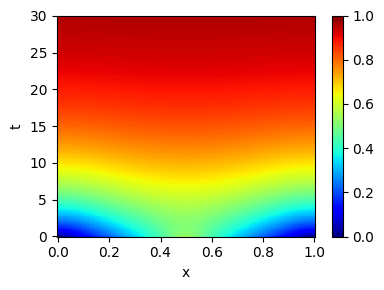

In [23]:
import matplotlib
plt.figure(figsize=(4,3))
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.0)
plt.pcolor(X, T, S, cmap='jet', norm=norm)

# 添加坐标轴标签和标题
plt.xlabel('x')
plt.ylabel('t')

# 添加颜色条
plt.colorbar()

# 调整布局
plt.tight_layout()

# 显示图像
plt.show()

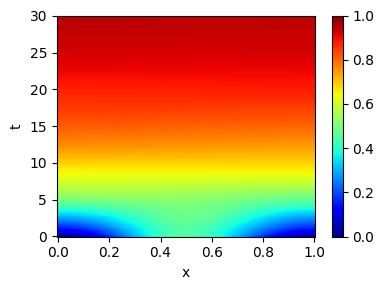

In [24]:
plt.figure(figsize=(4,3))
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.0)
plt.pcolor(X, T, pred_s, cmap='jet', norm=norm)

# 添加坐标轴标签和标题
plt.xlabel('x')
plt.ylabel('t')

# 添加颜色条
plt.colorbar()

# 调整布局
plt.tight_layout()

# 显示图像
plt.show()

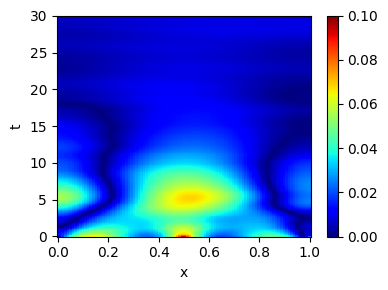

In [26]:
plt.figure(figsize=(4,3))
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.1)
plt.pcolor(X, T, abs(pred_s-S), cmap='jet', norm=norm)

# 添加坐标轴标签和标题
plt.xlabel('x')
plt.ylabel('t')

# 添加颜色条
plt.colorbar()

# 调整布局
plt.tight_layout()

# 显示图像
plt.show()